<a href="https://colab.research.google.com/github/Chumunaca/Chumunaca/blob/main/MODELOS%20IA%20MASTO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PRIMRO SE IMPORTAN LOS DATOS


In [82]:
# Importar librerías necesarias
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [83]:
# Cargar archivos CSV
metadata_df = pd.read_csv('metadata.csv')
breast_annotations_df = pd.read_csv('breast-level_annotations.csv')
finding_annotations_df = pd.read_csv('finding_annotations.csv')

In [84]:
# Convertir image_id a string para evitar problemas de unión
metadata_df["image_id"] = metadata_df["image_id"].astype(str)
breast_annotations_df["image_id"] = breast_annotations_df["image_id"].astype(str)
finding_annotations_df["image_id"] = finding_annotations_df["image_id"].astype(str)

In [85]:
# Unir metadata con anotaciones de mama (BI-RADS generales)
merged_df = metadata_df.merge(breast_annotations_df, on="image_id", suffixes=("_meta", "_breast"))


In [86]:
# Unir con anotaciones de hallazgos (lesiones)
merged_df = merged_df.merge(finding_annotations_df, on="image_id", how="left", suffixes=("", "_finding"))

In [87]:
# Mostrar las primeras filas para verificar la unión
print("Dataset combinado:")
print(merged_df.head())

Dataset combinado:
                           image_id                    series_id_meta  \
0  d8125545210c08e1b1793a5af6458ee2  b36517b9cbbcfd286a7ae04f643af97a   
1  290c658f4e75a3f83ec78a847414297c  b36517b9cbbcfd286a7ae04f643af97a   
2  cd0fc7bc53ac632a11643ac4cc91002a  b36517b9cbbcfd286a7ae04f643af97a   
3  71638b1e853799f227492bfb08a01491  b36517b9cbbcfd286a7ae04f643af97a   
4  dd9ce3288c0773e006a294188aadba8e  d931832a0815df082c085b6e09d20aac   

                   SOP Instance UID Patient's Age View Position  \
0  d8125545210c08e1b1793a5af6458ee2          053Y            CC   
1  290c658f4e75a3f83ec78a847414297c          053Y           MLO   
2  cd0fc7bc53ac632a11643ac4cc91002a          053Y            CC   
3  71638b1e853799f227492bfb08a01491          053Y           MLO   
4  dd9ce3288c0773e006a294188aadba8e          042Y            CC   

  Image Laterality Photometric Interpretation  Rows  Columns  \
0                L                MONOCHROME2  3518     2800   
1          

In [88]:
# Guardar el dataset unido en un nuevo CSV (opcional)
merged_df.to_csv('/content/dataset_completo.csv', index=False)
print("Archivo guardado como dataset_completo.csv")

Archivo guardado como dataset_completo.csv


###ANALISIS DESCRIPTIVO


In [89]:
# Verificar valores nulos
print("Valores nulos por columna:")
print(merged_df.isnull().sum())
#Esto nos dirá si hay imágenes sin etiquetas BI-RADS o sin información de lesiones.

Valores nulos por columna:
image_id                                 0
series_id_meta                           0
SOP Instance UID                         0
Patient's Age                         2316
View Position                            0
Image Laterality                         0
Photometric Interpretation               0
Rows                                     0
Columns                                  0
Imager Pixel Spacing                     0
Pixel Spacing                        16523
Pixel Padding Value                      0
Pixel Padding Range Limit            19361
Window Center                            0
Window Width                             0
Rescale Intercept                        0
Rescale Slope                            0
Rescale Type                             0
Window Center & Width Explanation        0
Manufacturer                             0
Manufacturer's Model Name                0
Unnamed: 21                          20486
study_id                   

Distribución de BI-RADS con porcentaje:
               Cantidad  Porcentaje
breast_birads                      
BI-RADS 1         13406   65.439813
BI-RADS 2          4676   22.825344
BI-RADS 4          1005    4.905789
BI-RADS 3           972    4.744704
BI-RADS 5           427    2.084350


<ipython-input-90-16fd7953472e>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=birads_df.index, y=birads_df["Cantidad"], palette="coolwarm")


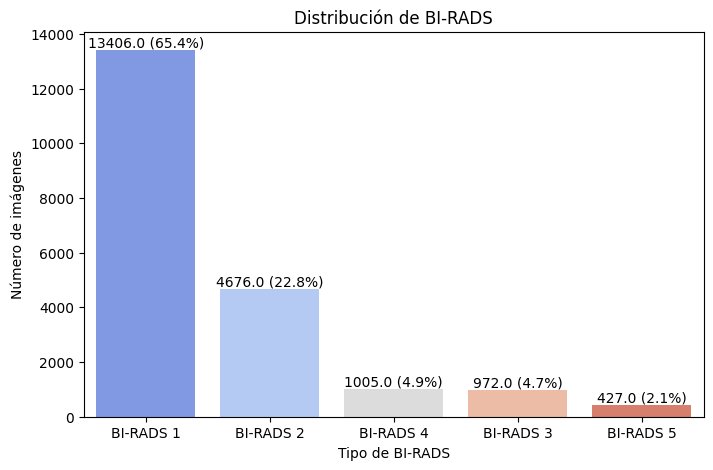

In [90]:
# Contar la cantidad y el porcentaje de cada BI-RADS
birads_counts = merged_df["breast_birads"].value_counts()
birads_percent = merged_df["breast_birads"].value_counts(normalize=True) * 100

# Combinar en un DataFrame para visualizar mejor
birads_df = pd.DataFrame({"Cantidad": birads_counts, "Porcentaje": birads_percent})
print("Distribución de BI-RADS con porcentaje:")
print(birads_df)

# Gráfico de barras con valores de porcentaje
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=birads_df.index, y=birads_df["Cantidad"], palette="coolwarm")

# Agregar los porcentajes sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/merged_df.shape[0]*100:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.title("Distribución de BI-RADS")
plt.xlabel("Tipo de BI-RADS")
plt.ylabel("Número de imágenes")
plt.show()
#Si hay pocas imágenes de BI-RADS 4 y 5, podríamos necesitar técnicas como Data Augmentation o balanceo de datos.

Tipos de hallazgos:
finding_categories
['No Finding']                                                                                      18232
['Mass']                                                                                             1123
['Suspicious Calcification']                                                                          402
['Focal Asymmetry']                                                                                   232
['Architectural Distortion']                                                                           95
['Asymmetry']                                                                                          90
['Suspicious Calcification', 'Mass']                                                                   82
['Suspicious Lymph Node']                                                                              57
['Skin Thickening']                                                                                    38
['Suspi

<ipython-input-91-1b708dedc4e6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=merged_df["finding_categories"], order=merged_df["finding_categories"].value_counts().index, palette="viridis")


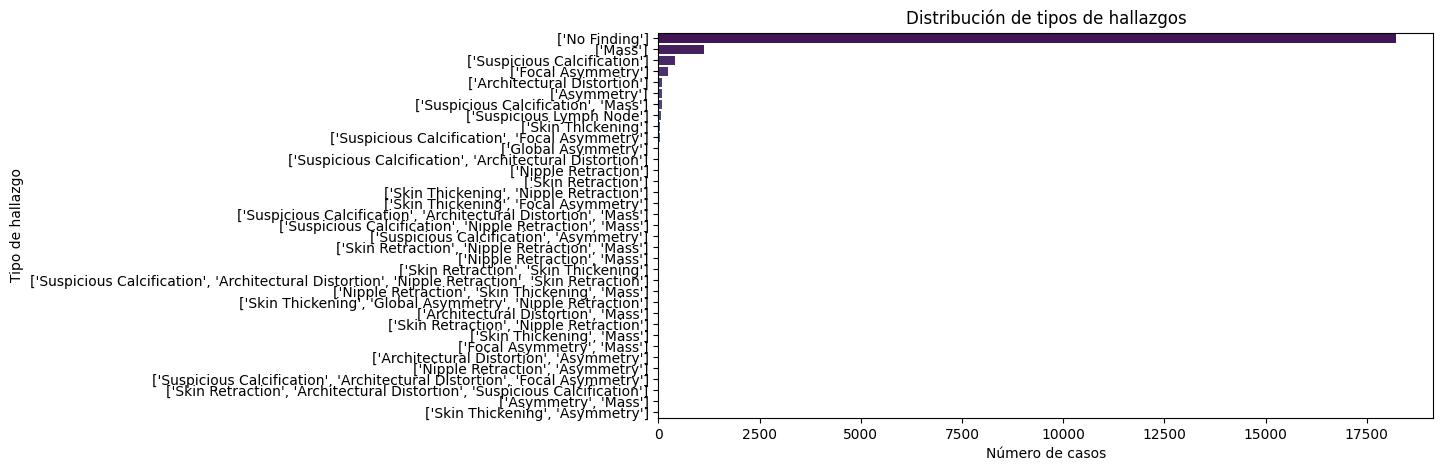

In [91]:
# Contar los tipos de hallazgos
print("Tipos de hallazgos:")
print(merged_df["finding_categories"].value_counts())

# Gráfico de barras
plt.figure(figsize=(10, 5))
sns.countplot(y=merged_df["finding_categories"], order=merged_df["finding_categories"].value_counts().index, palette="viridis")
plt.title("Distribución de tipos de hallazgos")
plt.xlabel("Número de casos")
plt.ylabel("Tipo de hallazgo")
plt.show()
# Si algunos hallazgos están poco representados, podríamos agruparlos para mejorar la clasificación.

breast_density  DENSITY A  DENSITY B  DENSITY C  DENSITY D
breast_birads                                             
BI-RADS 1              80       1326      10088       1912
BI-RADS 2               8        404       3624        640
BI-RADS 3               6         48        834         84
BI-RADS 4               7         78        850         70
BI-RADS 5               0        117        299         11


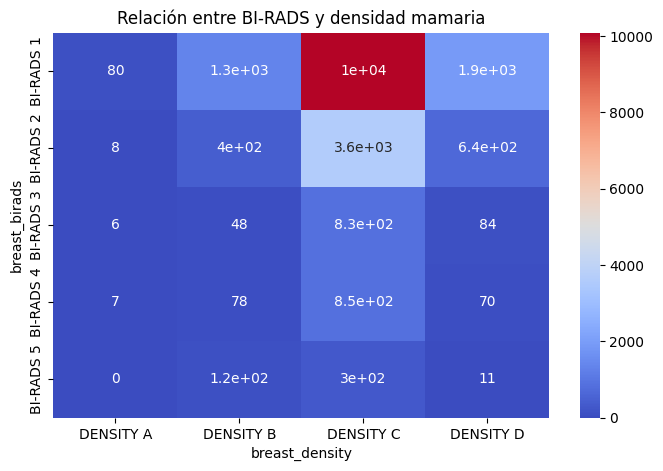

In [92]:
print(pd.crosstab(merged_df["breast_birads"], merged_df["breast_density"]))

# Gráfico de correlación
plt.figure(figsize=(8, 5))
sns.heatmap(pd.crosstab(merged_df["breast_birads"], merged_df["breast_density"]), annot=True, cmap="coolwarm")
plt.title("Relación entre BI-RADS y densidad mamaria")
plt.show()
# Esto nos dirá si las mamas más densas tienen más casos de BI-RADS altos.

Tamaño promedio de lesiones por BI-RADS:
               count           mean            std           min  \
breast_birads                                                      
BI-RADS 1        0.0            NaN            NaN           NaN   
BI-RADS 2       12.0   96272.995915   79247.315925  25648.258324   
BI-RADS 3      846.0   86673.698649  129505.750433   1077.928608   
BI-RADS 4      971.0  103375.779910  142765.410981    526.337280   
BI-RADS 5      425.0  173430.187465  221870.918285    544.726352   

                        25%           50%            75%           max  
breast_birads                                                           
BI-RADS 1               NaN           NaN            NaN           NaN  
BI-RADS 2      41945.617611  69676.337319  119340.043130  2.533849e+05  
BI-RADS 3      21248.096646  47711.333724   97339.070856  1.126633e+06  
BI-RADS 4      21806.379725  51013.093894  129418.466070  9.962392e+05  
BI-RADS 5      42473.089040  99970.562874  2

<ipython-input-93-42caa363fd74>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=merged_df["breast_birads"], y=merged_df["lesion_size"], palette="coolwarm")


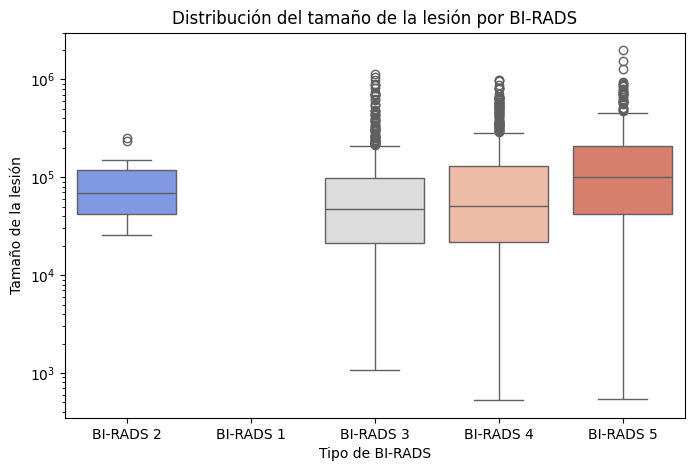

In [93]:
# Calcular el tamaño de cada lesión
merged_df["lesion_size"] = (merged_df["xmax"] - merged_df["xmin"]) * (merged_df["ymax"] - merged_df["ymin"])

# Ver estadísticas de tamaño según BI-RADS
print("Tamaño promedio de lesiones por BI-RADS:")
print(merged_df.groupby("breast_birads")["lesion_size"].describe())

# Gráfico de tamaño de lesión por BI-RADS
plt.figure(figsize=(8, 5))
sns.boxplot(x=merged_df["breast_birads"], y=merged_df["lesion_size"], palette="coolwarm")
plt.title("Distribución del tamaño de la lesión por BI-RADS")
plt.xlabel("Tipo de BI-RADS")
plt.ylabel("Tamaño de la lesión")
plt.yscale("log")  # Usamos escala logarítmica si los valores varían mucho
plt.show()

ALGUNOS TIPOS DE INFERENCIA


Contingency Table for breast_birads vs. breast_density:
breast_density  DENSITY A  DENSITY B  DENSITY C  DENSITY D
breast_birads                                             
BI-RADS 1              80       1326      10088       1912
BI-RADS 2               8        404       3624        640
BI-RADS 3               6         48        834         84
BI-RADS 4               7         78        850         70
BI-RADS 5               0        117        299         11

Chi-squared statistic: 305.9770246409768
P-value: 2.6084300779980932e-58
Hay una relación estadísticamente significativa entre breast_birads and breast_density.


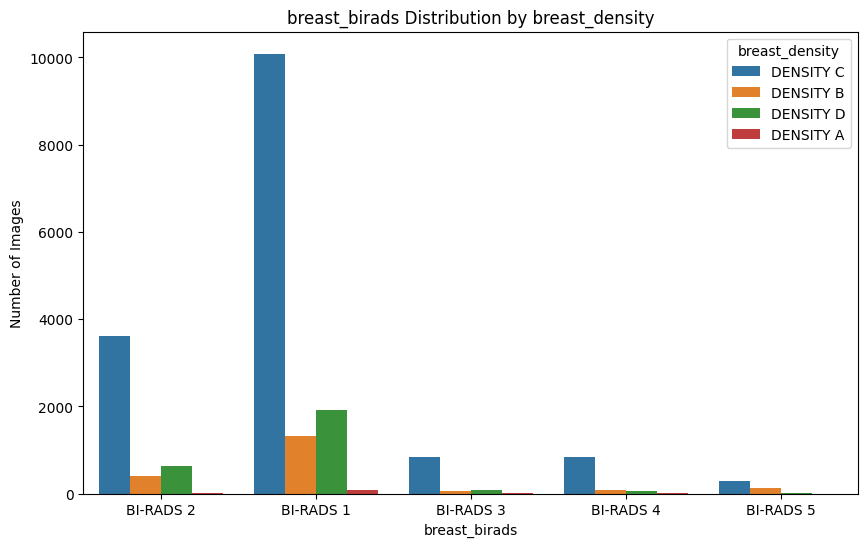


Contingency Table for breast_birads vs. Image Laterality:
Image Laterality     L     R
breast_birads               
BI-RADS 1         6656  6750
BI-RADS 2         2346  2330
BI-RADS 3          504   468
BI-RADS 4          524   481
BI-RADS 5          217   210

Chi-squared statistic: 3.998620461475063
P-value: 0.4061925821418664
No hay una relación estadísticamente significativa entre breast_birads and Image Laterality.


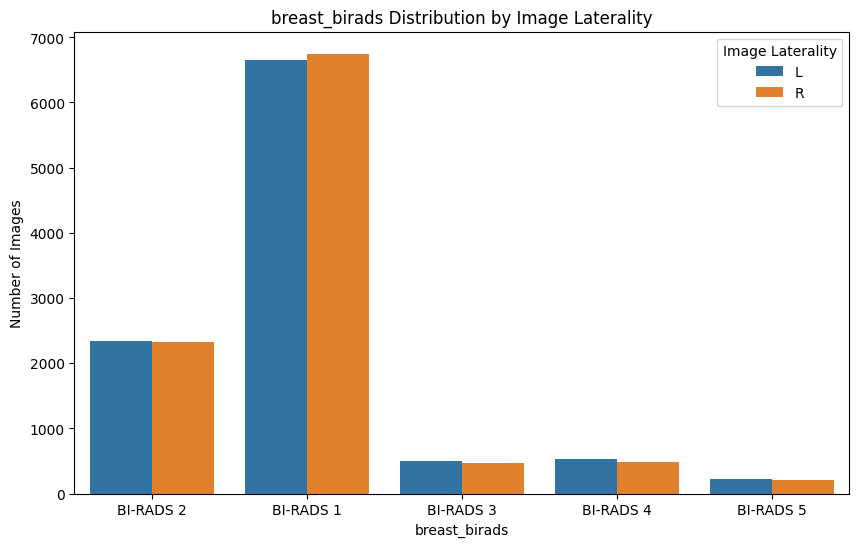


Contingency Table for breast_birads vs. View Position:
View Position    CC   MLO
breast_birads            
BI-RADS 1      6703  6703
BI-RADS 2      2339  2337
BI-RADS 3       487   485
BI-RADS 4       477   528
BI-RADS 5       191   236

Chi-squared statistic: 6.922398522081185
P-value: 0.14004637817628562
No hay una relación estadísticamente significativa entre breast_birads and View Position.


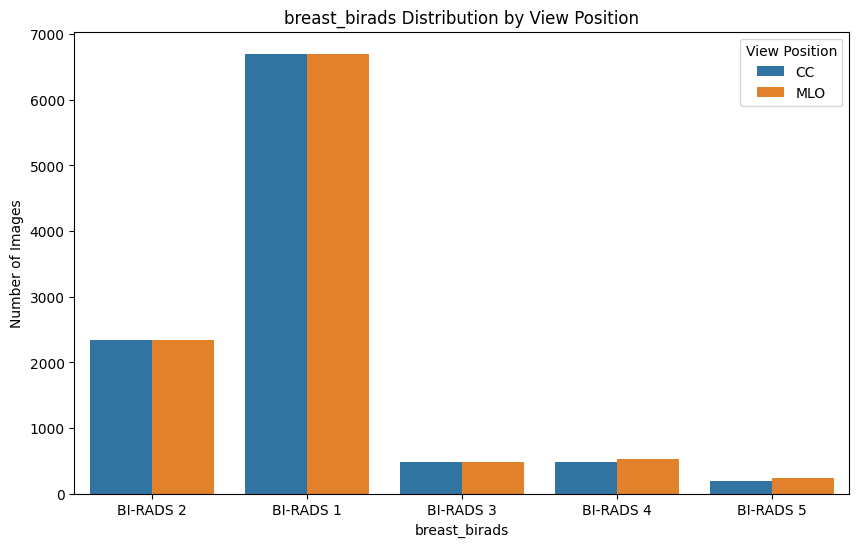

In [94]:

import pandas as pd
import matplotlib.pyplot as plt


from scipy.stats import chi2_contingency # import missing

def analyze_relationship(df, col1, col2):
    """
    Analyzes the relationship between two categorical variables using Chi-squared test and visualization.
    """
    contingency_table = pd.crosstab(df[col1], df[col2])
    print(f"\nContingency Table for {col1} vs. {col2}:\n{contingency_table}")

    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"\nChi-squared statistic: {chi2}")
    print(f"P-value: {p}")

    if p < 0.05:
        print(f"Hay una relación estadísticamente significativa entre {col1} and {col2}.") #missing bracket
    else:
        print(f"No hay una relación estadísticamente significativa entre {col1} and {col2}.") #missing bracket

    plt.figure(figsize=(10, 6))
    sns.countplot(x=col1, hue=col2, data=df)
    plt.title(f"{col1} Distribution by {col2}")
    plt.xlabel(col1)
    plt.ylabel("Number of Images")
    plt.show()


# Example usage:
analyze_relationship(merged_df, "breast_birads", "breast_density")
analyze_relationship(merged_df, "breast_birads", "Image Laterality")
analyze_relationship(merged_df, "breast_birads", "View Position")

plt.show()


In [95]:
# Reemplazar la 'Y' en Patient's Age y convertir a número (dejando NaN intactos)
merged_df["Patient's Age"] = merged_df["Patient's Age"].str.replace("Y", "").astype(float)
# Seleccionar las características para predecir la edad
features = ["breast_birads", "breast_density", "finding_categories"]  # Variables predictoras
target = "Patient's Age"  # Variable a predecir

In [96]:
import scipy.stats as stats
import pandas as pd

# Crear tabla de contingencia
contingency_table = pd.crosstab(merged_df["breast_birads"], merged_df["breast_density"])

# Realizar prueba de Chi-Cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Mostrar resultados
print("🔍 Prueba de Chi-Cuadrado entre BI-RADS y Densidad Mamaria:")
print(f"Chi2: {chi2:.2f}, p-valor: {p:.4f}")

# Interpretación
if p < 0.05:
    print("📌 Hay una asociación significativa entre BI-RADS y Densidad Mamaria.")
else:
    print("📌 No hay evidencia suficiente para afirmar que BI-RADS y Densidad Mamaria están relacionados.")


🔍 Prueba de Chi-Cuadrado entre BI-RADS y Densidad Mamaria:
Chi2: 305.98, p-valor: 0.0000
📌 Hay una asociación significativa entre BI-RADS y Densidad Mamaria.


<ipython-input-97-0954cf57b74e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=merged_df["breast_birads"], y=merged_df["Patient's Age"], palette="coolwarm")


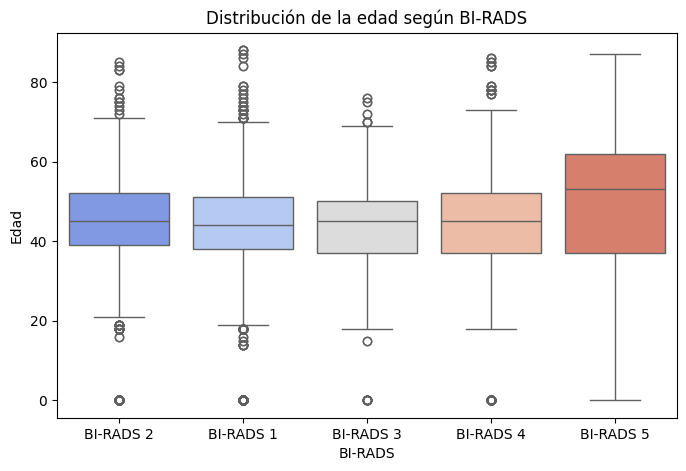

In [97]:
# Verificar normalidad de la edad en cada grupo de BI-RADS
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(x=merged_df["breast_birads"], y=merged_df["Patient's Age"], palette="coolwarm")
plt.title("Distribución de la edad según BI-RADS")
plt.xlabel("BI-RADS")
plt.ylabel("Edad")
plt.show()


In [100]:
from scipy.stats import kruskal

# Aplicar Kruskal-Wallis
kw_stat, p_kw = kruskal(*groups)

print("🔍 Prueba Kruskal-Wallis entre Edad y BI-RADS:")
print(f"Estadístico: {kw_stat:.2f}, p-valor: {p_kw:.4f}")

# Interpretación
if p_kw < 0.05:
    print("📌 Hay diferencias significativas en la edad según BI-RADS.")
else:
    print("📌 No hay diferencias significativas en la edad entre BI-RADS.")

🔍 Prueba Kruskal-Wallis entre Edad y BI-RADS:
Estadístico: 100.74, p-valor: 0.0000
📌 Hay diferencias significativas en la edad según BI-RADS.


In [101]:
# Crear tabla de contingencia entre BI-RADS y tipo de hallazgo
contingency_table_lesion = pd.crosstab(merged_df["breast_birads"], merged_df["finding_categories"])

# Prueba de Chi-Cuadrado
chi2_lesion, p_lesion, _, _ = stats.chi2_contingency(contingency_table_lesion)

# Mostrar resultados
print("🔍 Prueba de Chi-Cuadrado entre BI-RADS y Tipo de Lesión:")
print(f"Chi2: {chi2_lesion:.2f}, p-valor: {p_lesion:.4f}")

if p_lesion < 0.05:
    print("📌 Hay una asociación significativa entre BI-RADS y el tipo de lesión.")
else:
    print("📌 No hay evidencia suficiente para afirmar que el tipo de lesión afecta BI-RADS.")


🔍 Prueba de Chi-Cuadrado entre BI-RADS y Tipo de Lesión:
Chi2: 24755.86, p-valor: 0.0000
📌 Hay una asociación significativa entre BI-RADS y el tipo de lesión.


<ipython-input-102-bd44adef500d>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="breast_birads", y="lesion_size", data=merged_df, palette="Set3")


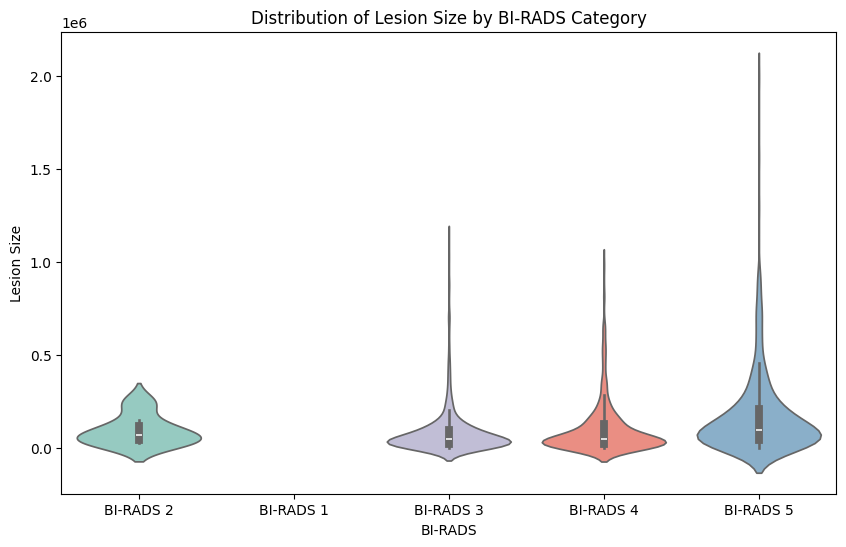

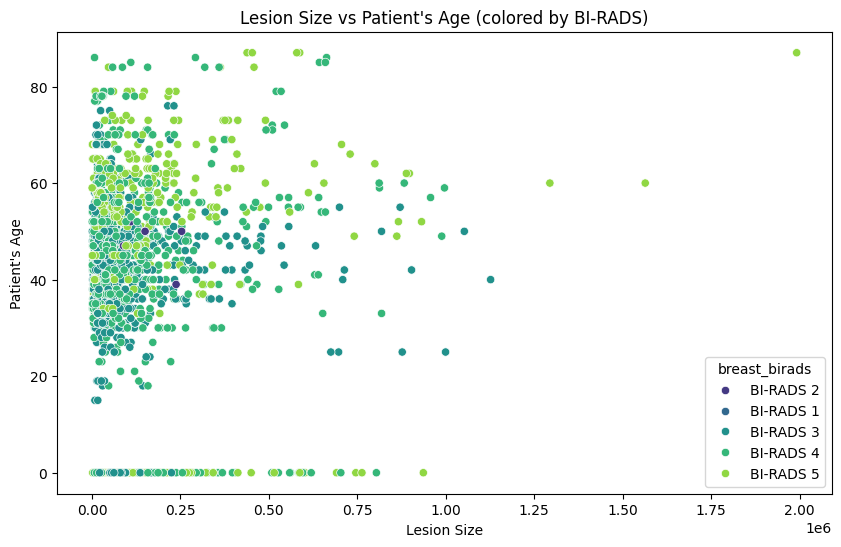

In [102]:
# prompt: Graficar las pruebas anteriores

import matplotlib.pyplot as plt
# Assuming the code you provided is in a Jupyter Notebook cell and the necessary libraries are already imported.
# The code already contains many visualizations.  If you want to add more, specify what you'd like to visualize.

# Example:  Visualize the distribution of lesion size for each BI-RADS category using a violin plot.
plt.figure(figsize=(10, 6))
sns.violinplot(x="breast_birads", y="lesion_size", data=merged_df, palette="Set3")
plt.title("Distribution of Lesion Size by BI-RADS Category")
plt.xlabel("BI-RADS")
plt.ylabel("Lesion Size")
plt.show()

# Example:  Scatter plot to visualize the relationship between lesion size and patient's age, colored by BI-RADS
plt.figure(figsize=(10, 6))
sns.scatterplot(x="lesion_size", y="Patient's Age", hue="breast_birads", data=merged_df, palette="viridis")
plt.title("Lesion Size vs Patient's Age (colored by BI-RADS)")
plt.xlabel("Lesion Size")
plt.ylabel("Patient's Age")
plt.show()

# Example:  Pairplot to see relationships between multiple numerical variables
# (May need to adjust based on your data - 'lesion_size' and 'Patient's Age' are examples)
# sns.pairplot(merged_df, vars=['lesion_size', "Patient's Age", 'xmax', 'ymax'], hue="breast_birads")
# plt.show() # Commented out to avoid potential memory issues with a large dataset and pairplot


# To add more visualizations, please specify:
# 1. What variables you want to plot.
# 2. The type of plot (e.g., histogram, boxplot, scatter plot, etc.)
# 3. Any other details you want (e.g., colors, labels, etc.)


In [103]:
# Convertir BI-RADS a número
merged_df["breast_birads"] = merged_df["breast_birads"].str.extract('(\d)').astype(float)

# Calcular la edad media por BI-RADS
age_mean_by_birads = merged_df.groupby("breast_birads")["Patient's Age"].mean()

# Rellenar NaN con la media correspondiente de su BI-RADS
merged_df["Patient's Age"] = merged_df.apply(
    lambda row: age_mean_by_birads[row["breast_birads"]] if pd.isnull(row["Patient's Age"]) else row["Patient's Age"],
    axis=1
)

# Convertir a enteros
merged_df["Patient's Age"] = merged_df["Patient's Age"].astype(int)

# Verificar que ya no haya valores nulos
print("✅ Valores nulos después de imputación:", merged_df["Patient's Age"].isnull().sum())

# Mostrar la media de edad por BI-RADS para confirmar
print("📌 Media de edad por BI-RADS utilizada para imputación:")
print(age_mean_by_birads)


✅ Valores nulos después de imputación: 0
📌 Media de edad por BI-RADS utilizada para imputación:
breast_birads
1.0    43.979527
2.0    44.737778
3.0    43.557778
4.0    42.793407
5.0    45.030612
Name: Patient's Age, dtype: float64


In [105]:
# Ver cuántos valores NaN hay en cada columna
print(merged_df.isnull().sum())
merged_df.head(5)

image_id                                 0
series_id_meta                           0
SOP Instance UID                         0
Patient's Age                            0
View Position                            0
Image Laterality                         0
Photometric Interpretation               0
Rows                                     0
Columns                                  0
Imager Pixel Spacing                     0
Pixel Spacing                        16523
Pixel Padding Value                      0
Pixel Padding Range Limit            19361
Window Center                            0
Window Width                             0
Rescale Intercept                        0
Rescale Slope                            0
Rescale Type                             0
Window Center & Width Explanation        0
Manufacturer                             0
Manufacturer's Model Name                0
Unnamed: 21                          20486
study_id                                 0
series_id_b

,image_id,series_id_meta,SOP Instance UID,Patient's Age,View Position,Image Laterality,Photometric Interpretation,Rows,Columns,Imager Pixel Spacing,...,breast_birads_finding,breast_density_finding,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split_finding,lesion_size
0,d8125545210c08e1b1793a5af6458ee2,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,53,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,NaN
1,290c658f4e75a3f83ec78a847414297c,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,53,MLO,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,NaN
2,cd0fc7bc53ac632a11643ac4cc91002a,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,53,CC,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,NaN
3,71638b1e853799f227492bfb08a01491,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,53,MLO,R,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,BI-RADS 2,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,NaN
4,dd9ce3288c0773e006a294188aadba8e,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,42,CC,L,MONOCHROME2,3518,2800,"[0.085, 0.085]",...,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training,NaN


In [106]:
# Guardar el dataset unido en un nuevo CSV (opcional)
merged_df.to_csv('/content/dataset_completo.IMPMEAN.csv', index=False)
print("Archivo guardado como dataset_completo.IMPMEAN.csv")

Archivo guardado como dataset_completo.IMPMEAN.csv


**ALGUNOS MODELOS **

In [113]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Convertir variables categóricas en numéricas
# Convertir BI-RADS

# The following line of code was indented before, which caused the error.
merged_df["breast_birads"] = merged_df["breast_birads"].astype(int)
# Convertir densidad a número usando Label Encoding
le = LabelEncoder()
merged_df["breast_density"] = le.fit_transform(merged_df["breast_density"])

# Convertir hallazgos a números
merged_df["finding_categories"] = merged_df["finding_categories"].astype("category").cat.codes

# Remove the following line because it was already taken care of in a previous cell
# merged_df["Patient's Age"] = merged_df["Patient's Age"].str.replace("Y", "").astype(int)

# Seleccionar características y variable objetivo
# The features list was modified to match column names.
# Remove "rows", and "columns" because they are not columns in the dataset
features = ["Patient's Age", "breast_density", "finding_categories"]
target = "breast_birads"

# Separar datos en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(merged_df[features], merged_df[target], test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Entrenar modelo SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Evaluar modelos
print("🔹 Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("🔹 SVM Accuracy:", accuracy_score(y_test, svm_preds))

# Reporte detallado de clasificación
print("\n📌 Reporte de clasificación para Random Forest:")
print(classification_report(y_test, rf_preds))

print("\n📌 Reporte de clasificación para SVM:")
print(classification_report(y_test, svm_preds))

🔹 Random Forest Accuracy: 0.7486578818936066
🔹 SVM Accuracy: 0.714738897022938

📌 Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           1       0.77      0.96      0.85      2692
           2       0.59      0.18      0.27       905
           3       0.68      0.67      0.67       207
           4       0.69      0.65      0.67       213
           5       0.69      0.58      0.63        81

    accuracy                           0.75      4098
   macro avg       0.69      0.61      0.62      4098
weighted avg       0.72      0.75      0.70      4098


📌 Reporte de clasificación para SVM:
              precision    recall  f1-score   support

           1       0.73      1.00      0.85      2692
           2       0.00      0.00      0.00       905
           3       0.55      0.78      0.64       207
           4       0.57      0.32      0.41       213
           5       0.58      0.09      0.15        81

    accuracy        

In [ ]:
######chat gpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.4 MB/s eta 0:00:00
🔹 Random Forest Accuracy: 0.7486578818936066
🔹 SVM Accuracy: 0.714738897022938
🔹 Neural Network Accuracy: 0.7223035627135188
🔹 CatBoost Accuracy: 0.7469497315763787

📌 Reporte de clasificación para Random Forest:
              precision    recall  f1-score   support

           1       0.77      0.96      0.85      2692
           2       0.59      0.18      0.27       905
           3       0.68      0.67      0.67       207
           4       0.69      0.65      0.67       213
           5       0.69      0.58      0.63        81

    accuracy                           0.75      4098
   macro avg       0.69      0.61      0.62      4098
weighted avg       0.72      0.75      0.70      4098


📌 Reporte de clasificación para SVM:
              precision    recall  f1-score   support

           1       0.73      1.00      0.85      2692
           2       0.00      0.00      0.00       905
           3       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


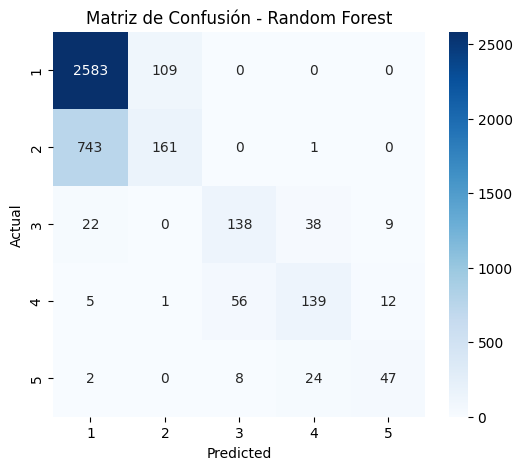


🔹 Matriz de Confusión para SVM:
[[2692    0    0    0    0]
 [ 904    0    0    1    0]
 [  33    1  162   11    0]
 [  20    1  119   68    5]
 [  15    4   16   39    7]]


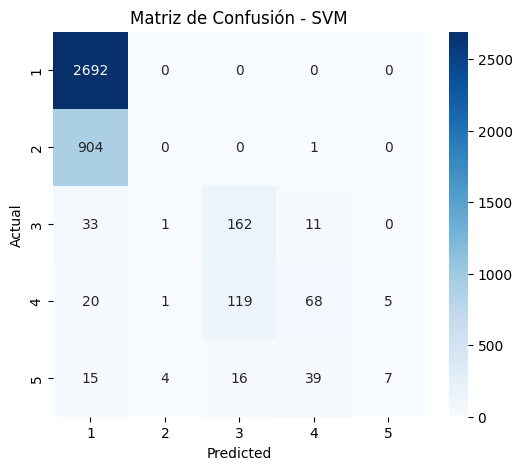


🔹 Matriz de Confusión para Red Neuronal:
[[2692    0    0    0    0]
 [ 904    0    0    1    0]
 [  22    0  142   35    8]
 [   6    0   82   87   38]
 [   9    0    8   25   39]]


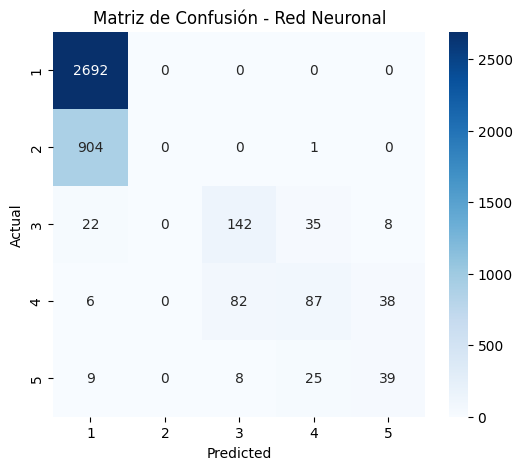


🔹 Matriz de Confusión para CatBoost:
[[2585  107    0    0    0]
 [ 745  159    0    1    0]
 [  22    0  140   37    8]
 [   5    0   61  128   19]
 [   2    0    8   22   49]]


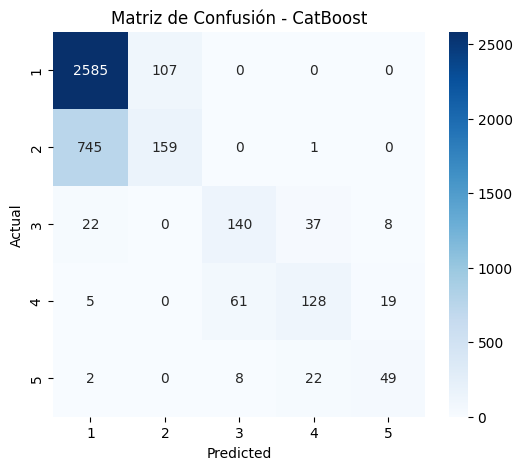

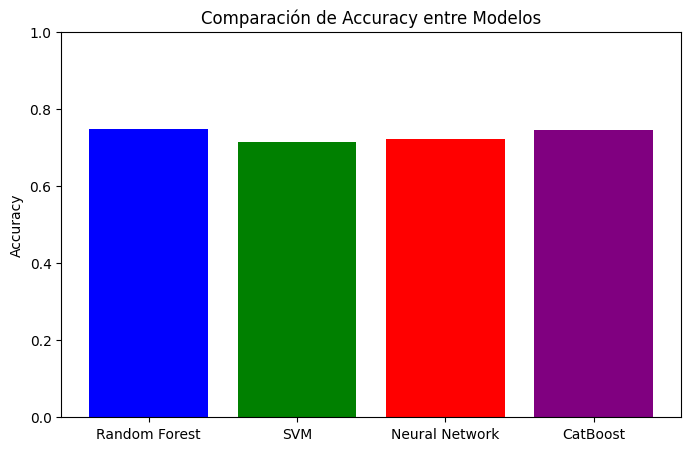

In [115]:
!pip install catboost
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Convertir variables categóricas en numéricas
merged_df["breast_birads"] = merged_df["breast_birads"].astype(int)
le = LabelEncoder()
merged_df["breast_density"] = le.fit_transform(merged_df["breast_density"])
merged_df["finding_categories"] = merged_df["finding_categories"].astype("category").cat.codes

# Seleccionar características y variable objetivo
features = ["Patient's Age", "breast_density", "finding_categories"]
target = "breast_birads"

# Separar datos en entrenamiento y prueba (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(merged_df[features], merged_df[target], test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# Entrenar modelo SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

# Entrenar modelo de Red Neuronal (MLP)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
nn_model.fit(X_train, y_train)
nn_preds = nn_model.predict(X_test)

# Entrenar modelo CatBoost
cat_model = CatBoostClassifier(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)

# Evaluar modelos
rf_acc = accuracy_score(y_test, rf_preds)
svm_acc = accuracy_score(y_test, svm_preds)
nn_acc = accuracy_score(y_test, nn_preds)
cat_acc = accuracy_score(y_test, cat_preds)

print("🔹 Random Forest Accuracy:", rf_acc)
print("🔹 SVM Accuracy:", svm_acc)
print("🔹 Neural Network Accuracy:", nn_acc)
print("🔹 CatBoost Accuracy:", cat_acc)

# Reportes de clasificación
print("\n📌 Reporte de clasificación para Random Forest:")
print(classification_report(y_test, rf_preds))
print("\n📌 Reporte de clasificación para SVM:")
print(classification_report(y_test, svm_preds))
print("\n📌 Reporte de clasificación para Neural Network:")
print(classification_report(y_test, nn_preds))
print("\n📌 Reporte de clasificación para CatBoost:")
print(classification_report(y_test, cat_preds))

# Función para mostrar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

# Mostrar matrices de confusión
print("\n🔹 Matriz de Confusión para Random Forest:")
print(confusion_matrix(y_test, rf_preds))
plot_confusion_matrix(y_test, rf_preds, "Random Forest")

print("\n🔹 Matriz de Confusión para SVM:")
print(confusion_matrix(y_test, svm_preds))
plot_confusion_matrix(y_test, svm_preds, "SVM")

print("\n🔹 Matriz de Confusión para Red Neuronal:")
print(confusion_matrix(y_test, nn_preds))
plot_confusion_matrix(y_test, nn_preds, "Red Neuronal")

print("\n🔹 Matriz de Confusión para CatBoost:")
print(confusion_matrix(y_test, cat_preds))
plot_confusion_matrix(y_test, cat_preds, "CatBoost")

# Gráfica comparativa de accuracy
models = ['Random Forest', 'SVM', 'Neural Network', 'CatBoost']
accuracies = [rf_acc, svm_acc, nn_acc, cat_acc]
plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.show()


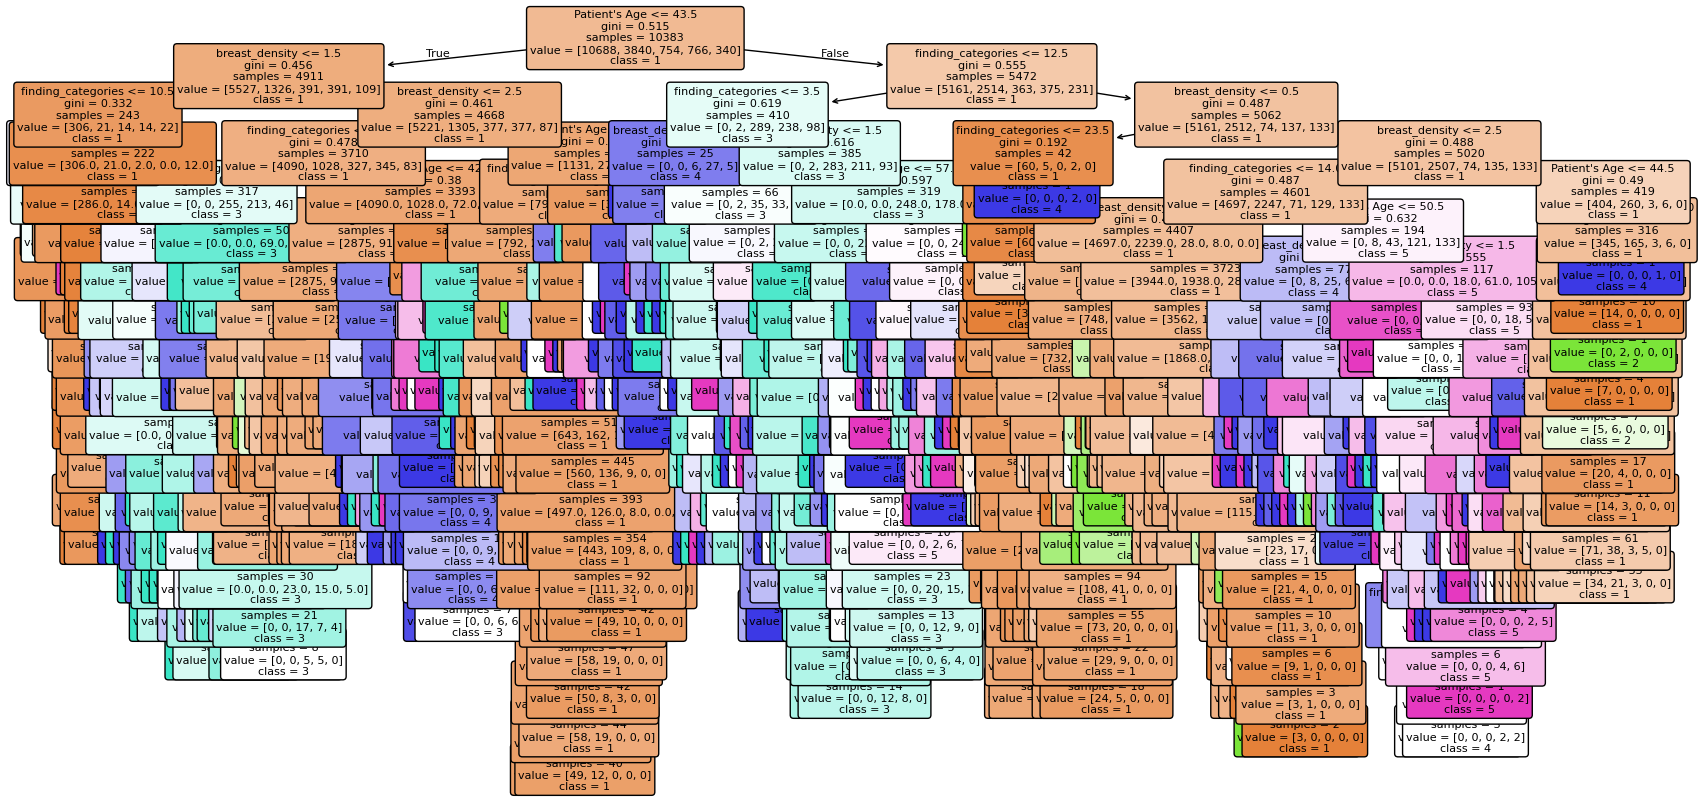

Arquitectura de la Red Neuronal:


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [116]:
# prompt: graficar red neuronal del neural network

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
# ... (your existing code) ...

# Visualizar un árbol de decisión del Random Forest (ejemplo)
plt.figure(figsize=(20,10))
plot_tree(rf_model.estimators_[0],
          feature_names=features,
          class_names=[str(x) for x in sorted(set(y_train))],
          filled=True,
          rounded=True,
          fontsize=8)
plt.show()

# Para visualizar la red neuronal, se puede usar una librería como "NN-SVG"
# pero la representación de una red compleja puede ser difícil de interpretar visualmente.
# Una opción alternativa es mostrar la arquitectura de la red:
print("Arquitectura de la Red Neuronal:")
nn_model


🔹 Decision Tree Accuracy: 0.7484138604197169

📌 Reporte de clasificación para Decision Tree:
              precision    recall  f1-score   support

           1       0.77      0.96      0.85      2692
           2       0.60      0.17      0.27       905
           3       0.67      0.67      0.67       207
           4       0.67      0.65      0.66       213
           5       0.75      0.56      0.64        81

    accuracy                           0.75      4098
   macro avg       0.69      0.60      0.62      4098
weighted avg       0.72      0.75      0.70      4098


🔹 Matriz de Confusión para Decision Tree:
[[2588  104    0    0    0]
 [ 746  158    0    1    0]
 [  22    0  138   41    6]
 [   5    1   60  138    9]
 [   2    0    9   25   45]]


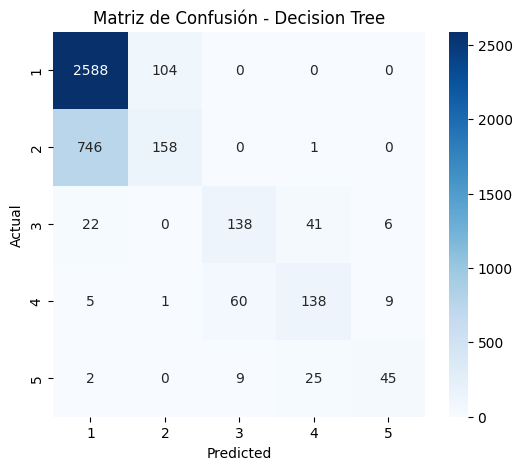

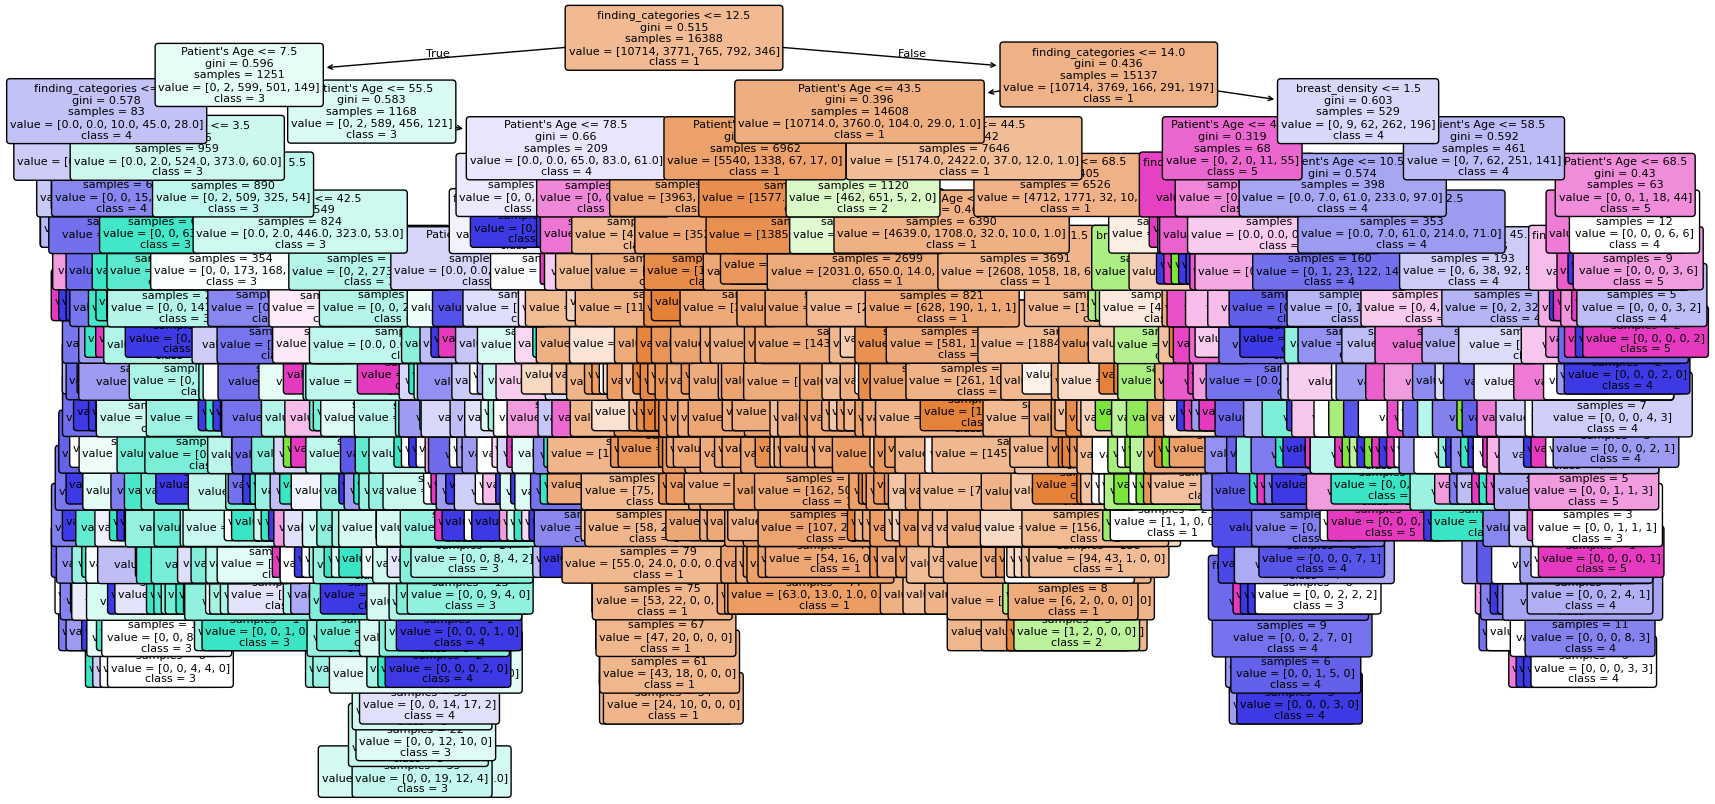

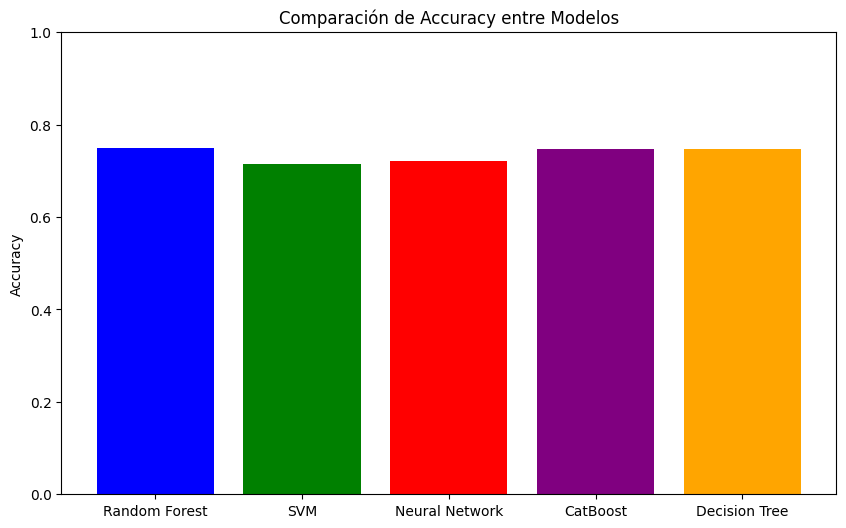

In [117]:
# prompt: Mejora la red neuronal, haz el arbol de decisión

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# ... (your existing code) ...


# Entrenar modelo de Árbol de Decisión
dt_model = DecisionTreeClassifier(random_state=42)  # Puedes ajustar hiperparámetros
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

# Evaluar el modelo de árbol de decisión
dt_acc = accuracy_score(y_test, dt_preds)
print("🔹 Decision Tree Accuracy:", dt_acc)
print("\n📌 Reporte de clasificación para Decision Tree:")
print(classification_report(y_test, dt_preds))


# Mostrar matriz de confusión para Decision Tree
print("\n🔹 Matriz de Confusión para Decision Tree:")
print(confusion_matrix(y_test, dt_preds))
plot_confusion_matrix(y_test, dt_preds, "Decision Tree") # Assuming plot_confusion_matrix is defined as in your previous code


# Visualizar el árbol de decisión
plt.figure(figsize=(20,10))
plot_tree(dt_model,
          feature_names=features,
          class_names=[str(x) for x in sorted(set(y_train))],
          filled=True,
          rounded=True,
          fontsize=8)
plt.show()

# Actualizar la gráfica comparativa de accuracy
models = ['Random Forest', 'SVM', 'Neural Network', 'CatBoost', 'Decision Tree']
accuracies = [rf_acc, svm_acc, nn_acc, cat_acc, dt_acc]
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparación de Accuracy entre Modelos')
plt.show()
